# Intensity resolution for selected images

**Description:**

This benchmark checks how well the intensity parameter (total reconstructed charge in pixels surviving cleaning, i.e. the parameter traditionally known as image "Size") correlates with the true number of photoelectrons from Cherenkov photons in the whole camera (that is, in all pixels, regardless whether or not they survive cleaning).

This correlation is relevant, above all, for the energy reconstruction.

We do this check for the images which survive the intensity and image c.o.g. cuts plus a cut on maximum impact parameter of 200 m.

**Data level:** DL1a + DL1b (telescope-wise true/reconstructed images and image parameters)

**Note:**

Any bias present at calibration level (due for example to CALIB_SCALE and/or charge integration correction) as well as the fact that the charge in pixels rejected by the cleaning is not counted in the calculation of intensity will cause the intensity parameter to be systematically smaller than the actual number of photoelectrons.

The impact parameter cut takes into account charges which arrive after the end of the readout window due to large impact parameters.

The stronger bias seen for intensity values around ~2e4 is due to saturation at the pixel level.

**Requirements and steps to reproduce**

This notebook can be used with any file produced by ``protopipe-TRAINING``, but it is meant to be used with the whole statistics of the ``gamma1`` sample (energy model training), especially if comparing with the 2019 release of the CTAMARS analysis described [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki).

To get a filled notebook and reproduce these results,

- get the necessary input files using ``protopipe-TRAINING`` using the gamma1 sample and saving the images (see documentation)
- execute the notebook with ``protopipe-BENCHMARK``,

``protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n TRAINING/benchmarks_DL1_image_intensity_resolution``

To obtain the list of all available parameters add ``--help-notebook``.

**Comparison against CTAMARS:**

- reference simtel-files, plots, values and settings can be found [here (please, always refer to the latest version)](https://forge.in2p3.fr/projects/benchmarks-reference-analysis/wiki/Comparisons_between_pipelines).

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.   
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.  
Please, strip the output before pushing.

## Table of contents
- [Distributions](#Distributions)
- [Mean and RMS as error bar of intensity profile](#Mean-and-RMS-as-error-bar-of-intensity-profile)
- [RMS/Mean](#RMS/Mean)

## Imports 

In [1]:
from pathlib import Path

import tables
import numpy as np
from scipy.stats import binned_statistic
from astropy.table import join
import astropy.units as u
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import uproot

from ctapipe.io import read_table

from protopipe.pipeline.utils import CTAMARS_radii
from protopipe.pipeline.utils import load_config

## Functions

In [2]:
def sum_of_squares(x):
    x = np.asanyarray(x)
    if len(x) == 0: return 0
    mean = x.mean()
    return np.sum((x - mean)**2)

In [3]:
class OnlineBinnedStats:
    def __init__(self, bin_edges):
        self.bin_edges = bin_edges
        self.n_bins = len(bin_edges) - 1
        self.n = np.zeros(self.n_bins)
        self._mean = np.zeros(self.n_bins)
        self._m2 = np.zeros(self.n_bins)
    def update(self, x, values):
        n = binned_statistic(x, values, 'count', self.bin_edges).statistic
        mean = binned_statistic(x, values, 'mean', bins=self.bin_edges).statistic
        m2 = binned_statistic(x, values, sum_of_squares, bins=self.bin_edges).statistic
        
        # empty bins are nan, but we need 0
        empty = n == 0
        mean[empty] = 0
        m2[empty] = 0
        
        n_total = self.n + n
        delta = self._mean - mean
        v = n_total > 0 # to avoid dividing by 0 and remove more NaNs
        self._mean[v] = (self.n[v] * self._mean[v] + n[v] * mean[v]) / n_total[v]
        self._m2[v] += m2[v] + delta[v]**2 * self.n[v] * n[v] / n_total[v]
        self.n = n_total
    @property
    def mean(self):
        mean = np.full(self.n_bins, np.nan)
        valid = self.n > 0
        mean[valid] = self._mean[valid]
        return mean
    @property
    def std(self):
        std = np.full(self.n_bins, np.nan)
        valid = self.n > 1
        std[valid] = np.sqrt(self._m2[valid] / (self.n[valid] - 1))
        return std
    @property
    def bin_centers(self):
        return 0.5 * (self.bin_edges[:-1] + self.bin_edges[1:])
    @property
    def bin_width(self):
        return np.diff(self.bin_edges)

## Input data

In [4]:
analyses_directory = ""  # path to the 'analyses' folder
output_directory = Path.cwd() # default output directory for plots
analysis_name = "" # Name of the analysis stored in 'analyses_folder'
input_filename = "TRAINING_energy_tail_gamma_merged.h5"  # Name of the file produced with protopipe
nth_chunk = None # int, read up to the first chunk of 10l images (default: None, full dataset)
load_CTAMARS = True # Enable to compare the CTAN analysis done with CTAMARS (Release 2019)
input_directory_CTAMARS = {}
input_directory_CTAMARS["parent_directory"] = "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data"
input_directory_CTAMARS["TRAINING/DL1"] = "TRAINING/DL1"

In [5]:
# Parameters
analyses_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/shared_folder/analyses"
analysis_name = "v0.5.0a1"
analysis_name_2 = ""
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_directory_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "",
    "DL3": "DL3",
}
load_EventDisplay = True
EventDisplay_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203"
input_simtel_file = "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz"
input_filenames = {
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
output_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/shared_folder/analyses/v0.5.0a1/benchmarks_results/TRAINING"


In [6]:
if not input_filename:
    try:
        input_filename = input_filenames["TRAINING_energy_gamma"]
    except (NameError, KeyError):
        raise ValueError("ERROR: input_filename undefined.")

if not Path(analyses_directory).is_dir():
    raise ValueError("ERROR: analyses_directory undefined or not existent.")

input_directory = Path(analyses_directory) / analysis_name / Path("data/TRAINING/for_energy_estimation")
input_file = input_directory / input_filename

In [7]:
if load_CTAMARS:
    
    # Get input file path
    if (input_directory_CTAMARS["parent_directory"] is None) or (input_directory_CTAMARS["TRAINING/DL1"] is None):
        raise ValueError("ERROR: CTAMARS data undefined. Please, check the documentation of protopipe-BENCHMARKS.")
    else:

        mars_dl1b_fileName = "check_dl1b.root"

        path_mars_dl1b = Path(input_directory_CTAMARS["parent_directory"]) / input_directory_CTAMARS["TRAINING/DL1"] / mars_dl1b_fileName
        ctamars_dl1b = uproot.open(path_mars_dl1b)

        CTAMARS_data = {}
        with uproot.open(path_mars_dl1b) as file:

            for key in file.keys():
                CTAMARS_data[key[:-2]] = file[key[:-2]]

In [8]:
# get camera names
with tables.open_file(input_file, 'r') as f:
    
    cameras = [cam.name for cam in f.root]

In [9]:
# setup the initial data

H = dict.fromkeys(cameras)
stats = dict.fromkeys(cameras)

for i, camera in enumerate(cameras):
    
    # Counts histogram
    
    if load_CTAMARS:
    
        x_bin_edges_counts = CTAMARS_data[f"PheOverSize_vs_Size_type{i}"].to_numpy()[1]
        y_bin_edges_counts = CTAMARS_data[f"PheOverSize_vs_Size_type{i}"].to_numpy()[2]

    else:

        x_bin_edges_counts = np.linspace(1.298, 5.298, 200)
        y_bin_edges_counts = np.linspace(0., 4., 200)
        
    x = np.zeros(len(x_bin_edges_counts)-1)
    y = np.zeros(len(x_bin_edges_counts)-1)
    
    H[camera], _, _ = np.histogram2d(x, y, bins=(x_bin_edges_counts, y_bin_edges_counts))
    
    # Profiled histogram
    
    if load_CTAMARS:
        x_bin_edges_profile = CTAMARS_data[f"relative_rms_{i}"].to_numpy()[1]
        #y_bin_edges_profile = CTAMARS_data[f"relative_rms_{i}"].to_numpy()[1]
    else:
        x_bin_edges_profile = np.arange(1.298, 5.498, 0.2)
        #y_bin_edges_profile = np.arange(0, 4, 0.2)
    
    stats[camera] = OnlineBinnedStats(x_bin_edges_profile)

In [10]:
with tables.open_file(input_file, 'r') as f:

    n_rows = {cam: len(f.root[cam]) for cam in cameras}
    print(f"Total number of images at input per camera = {n_rows}")
    
    chunksize = 10000
    
    for camera in cameras:
    
        n_chunks = int(np.ceil(n_rows[camera] / chunksize))
        
        for chunk in range(n_chunks):
            
            start = chunk * chunksize
            stop = (chunk + 1) * chunksize
            t = read_table(f, f'/{camera}', start=start, stop=stop)

            if load_CTAMARS:
                selected_images = t[(t["hillas_intensity"]>50.) & 
                                    (t["hillas_r"]<0.8*CTAMARS_radii(camera)) &
                                    (t["impact_dist"]<200.) &
                                    (t["image_extraction"]==1)]
                hillas_intensity = selected_images["hillas_intensity"]
                tot_true_phe = np.sum(selected_images["true_image"], axis=1)
            else:
                hillas_intensity = t["hillas_intensity"]
                tot_true_phe = np.sum(t["true_image"], axis=1)

            X = np.log10(hillas_intensity)
            Y = tot_true_phe / hillas_intensity
            
            ###### 2D histogram

            H[camera] += np.histogram2d(x = X, 
                                        y = Y,
                                        bins=(x_bin_edges_counts, y_bin_edges_counts))[0]
            
            ###### Profiled histogram
            
            stats[camera].update(X, Y)
            
            if nth_chunk and (chunk > int(n_chunks/nth_chunk)):
                break

Total number of images at input per camera = {'LSTCam': 2158224, 'NectarCam': 2382502}


In [11]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

## Distributions
[back to top](#Table-of-contents)

Total number of SELECTED LSTCam images:
protopipe = 809386.0
CTAMARS = 889351.0


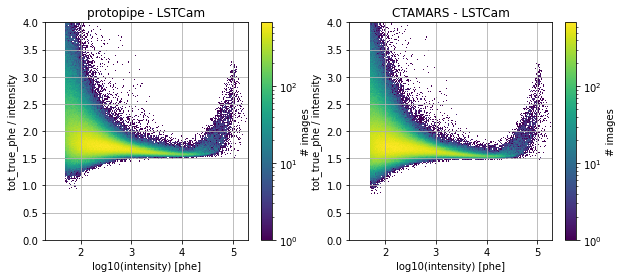

Total number of SELECTED NectarCam images:
protopipe = 1021593.0
CTAMARS = 1063525.0


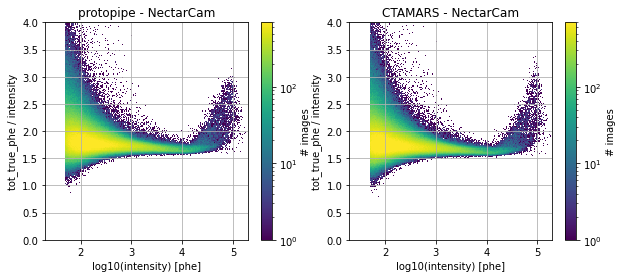

In [12]:
max_counts = {}
if load_CTAMARS:
    for i, camera in enumerate(cameras):
        max_counts[camera] = CTAMARS_data[f"PheOverSize_vs_Size_type{i}"].to_numpy()[0].max()
    else:
        max_counts[camera] = 700

for i, camera in enumerate(cameras):
    
    print(f"Total number of SELECTED {camera} images:")
    print(f"protopipe = {np.sum(H[camera])}")
    if load_CTAMARS:
        print(f"CTAMARS = {np.sum(CTAMARS_data[f'PheOverSize_vs_Size_type{i}'].to_numpy()[0])}")
    
    if not load_CTAMARS:
        plt.figure(figsize=(10,6))
        plt.title(camera)
    else:
        plt.figure(figsize=(10,4))
        plt.subplots_adjust(hspace=0.4)
        plt.subplot(1, 2, 1)
        plt.title(f"protopipe - {camera}")

    plt.pcolormesh(x_bin_edges_counts, 
                   y_bin_edges_counts, 
                   H[camera].T,
                   norm=LogNorm(vmax=max_counts[camera]),
                   cmap="viridis"
                   )
    cbar = plt.colorbar()
    cbar.set_label("# images")

    
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("tot_true_phe / intensity")

    plt.grid(which="both", axis="both")
    
    if load_CTAMARS:
        plt.subplot(1, 2, 2)
        plt.title(f"CTAMARS - {camera}")
        
        plt.pcolormesh(x_bin_edges_counts, 
                       y_bin_edges_counts, 
                       CTAMARS_data[f"PheOverSize_vs_Size_type{i}"].to_numpy()[0].T,
                       norm=LogNorm(vmax=max_counts[camera]),
                       cmap="viridis"
                       )
        
        cbar = plt.colorbar()
        cbar.set_label("# images")

        plt.xlabel("log10(intensity) [phe]")
        plt.ylabel("tot_true_phe / intensity")

        plt.grid(which="both", axis="both")
    
    plt.savefig(plots_folder / f"correlation_intensity_trueCharge_distribution_{camera}_protopipe_{analysis_name}.png")
    
    plt.show()

## Mean and RMS as error bar of intensity profile
[back to top](#Table-of-contents)

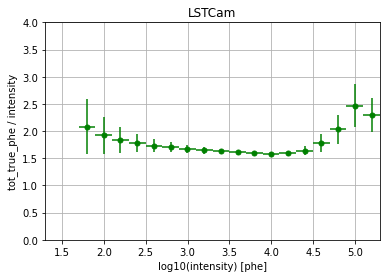

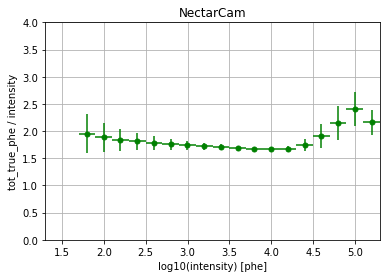

In [13]:
for camera in cameras:
    
    plt.figure()
    
    plt.errorbar(x = stats[camera].bin_centers, 
                 y = stats[camera].mean, 
                 yerr=stats[camera].std, 
                 xerr=stats[camera].bin_width / 2,
                 fmt='go',
                 ecolor="g",
                 markersize=5)
    
    plt.title(camera)
    plt.xlim(np.min(x_bin_edges_counts),np.max(x_bin_edges_counts))
    plt.ylim(np.min(y_bin_edges_counts),np.max(y_bin_edges_counts))
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("tot_true_phe / intensity")
    
    plt.grid(which="both", axis="both")
    
    plt.savefig(plots_folder / f"correlation_intensity_trueCharge_mean+RMSerrorbar_{camera}_protopipe_{analysis_name}.png")
    
    plt.show()

## RMS/Mean
[back to top](#Table-of-contents)

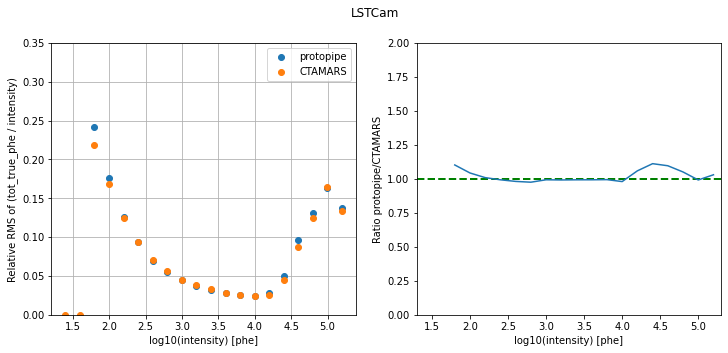

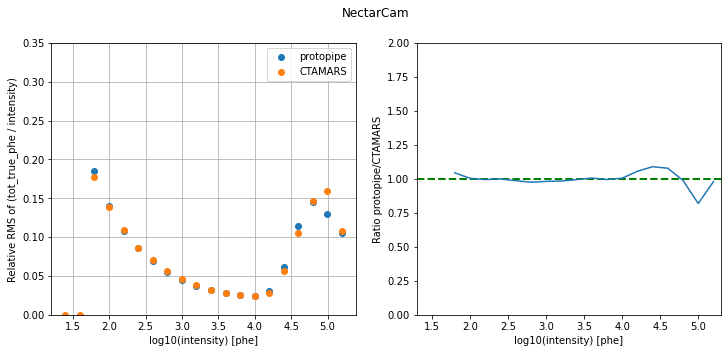

In [14]:
for i, camera in enumerate(cameras):
    
    plt.figure(figsize=(12,5))
    plt.subplots_adjust(hspace=0.3)
    plt.suptitle(camera)
    
    plt.subplot(1,2,1)
    
    plt.plot(stats[camera].bin_centers, stats[camera].std/stats[camera].mean, 'o', label="protopipe")
    
    if load_CTAMARS:
        plt.plot(stats[camera].bin_centers, CTAMARS_data[f"relative_rms_{i}"].to_numpy()[0], "o", label="CTAMARS")
    
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("Relative RMS of (tot_true_phe / intensity)")
    plt.ylim(0,0.35)
    
    plt.grid(which="both", axis="both")
    
    plt.legend()
    
    plt.subplot(1,2,2)
    
    ratio = (stats[camera].std/stats[camera].mean) / CTAMARS_data[f"relative_rms_{i}"].to_numpy()[0]
    plt.plot(stats[camera].bin_centers, ratio)
    plt.xlabel("log10(intensity) [phe]")
    plt.ylabel("Ratio protopipe/CTAMARS")
    plt.ylim(0,2)
    plt.xlim(np.min(x_bin_edges_counts),np.max(x_bin_edges_counts))
    ax = plt.gca()
    xlims = ax.get_xlim()
    plt.hlines(1.0, xmin=xlims[0], xmax=xlims[1], ls="--", lw=2, color="green")
    
    plt.savefig(plots_folder / f"correlation_intensity_trueCharge_meanRMSratio_{camera}_protopipe_{analysis_name}.png")
    
    plt.show()